## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/lasso/lasso_lsqr.html")


code =

    'function [z, history] = lasso_lsqr(A, b, lambda, rho, alpha)
     % lasso_lsqr Solve lasso problem via ADMM
     %
     % [z, history] = lasso_lsqr(A, b, lambda, rho, alpha);
     % 
     % Solves the following problem via ADMM:
     %
     %   minimize 1/2*|| Ax - b ||_2^2 + \lambda || x ||_1,
     % 
     % where A is a sparse matrix. This uses LSQR for the x-update instead.
     %
     % The solution is returned in the vector x.
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     % 
     % rho is the augmented Lagrangian parameter. 
     %
     % alpha is the over-relaxation parameter (typical values for alpha are 
     % between 1.0 and 1.8).
     %
     %
     % More information can be found in the paper linked at:
     % http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
     %
     
     t_star

In [2]:
%%file lasso_lsqr.m

function [z, history] = lasso_lsqr(A, b, lambda, rho, alpha)
% lasso_lsqr Solve lasso problem via ADMM
%
% [z, history] = lasso_lsqr(A, b, lambda, rho, alpha);
%
% Solves the following problem via ADMM:
%
%   minimize 1/2*|| Ax - b ||_2^2 + \lambda || x ||_1,
%
% where A is a sparse matrix. This uses LSQR for the x-update instead.
%
% The solution is returned in the vector x.
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%

t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

%% Data preprocessing

[m, n] = size(A);

%% ADMM solver

x = zeros(n,1);
z = zeros(n,1);
u = zeros(n,1);


if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
    'lsqr iters', 'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

for k = 1:MAX_ITER

    % x-update with lsqr; uses previous x to warm start
    [x, flag, relres, iters] = lsqr([A; sqrt(rho)*speye(n)], ...
        [b; sqrt(rho)*(z-u)], [], [], [], [], x);

    if(flag ~=0)
        error('LSQR problem...\n');
    end

    % z-update with relaxation
    zold = z;
    x_hat = alpha*x + (1 - alpha)*zold;
    z = shrinkage(x_hat + u, lambda/rho);

    u = u + (x_hat - z);

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, b, lambda, x, z);

    history.lsqr_iters(k) = iters;
    history.r_norm(k)  = norm(x - z);
    history.s_norm(k)  = norm(-rho*(z - zold));

    history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z));
    history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*norm(rho*u);

    if ~QUIET
        fprintf('%3d\t%10d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
            sum(history.lsqr_iters), history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end

    if (history.r_norm(k) < history.eps_pri(k) && ...
      history.s_norm(k) < history.eps_dual(k))
        break;
    end

end

if ~QUIET
    toc(t_start);
end
end

function p = objective(A, b, lambda, x, z)
    p = ( 1/2*sum((A*x - b).^2) + lambda*norm(z,1) );
end

function z = shrinkage(x, kappa)
    z = max( 0, x - kappa ) - max( 0, -x - kappa );
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/lasso_lsqr.m'.


# Example

In [5]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/lasso/lasso_lsqr_example.html")


eg_code =

    '% L1-regularized least-squares example for sparse A
     
     %% Generate problem data
     
     randn('seed', 0);
     rand('seed',0);
     
     m  = 1000000;   % number of examples
     n  = 10000;     % number of features
     p1 = 0.001;     % sparsity density of solution vector 
     p2 = 0.0001;    % sparsity density of A
     
     x0 = sprandn(n, 1, p1);
     A = sprandn(m, n, p2);
     b = A*x0 + 0.1*randn(m,1);
     
     lambda_max = norm(A'*b, 'inf');
     lambda = 0.1*lambda_max; 
     
     %% Solve problem
     
     [x history] = lasso_lsqr(A, b, lambda, 1.0, 1.0);
     
     %% Reporting
     K = length(history.objval);                                                                                                        
     
     h = figure;
     plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2); 
     ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');
     
     g = figure;
     subplot(2,1,1);                                         

### Generate problem data

In [6]:
randn('seed', 0);
rand('seed',0);

m  = 1000000;   % number of examples
n  = 10000;     % number of features
p1 = 0.001;     % sparsity density of solution vector
p2 = 0.0001;    % sparsity density of A

x0 = sprandn(n, 1, p1);
A = sprandn(m, n, p2);
b = A*x0 + 0.1*randn(m,1);

lambda_max = norm(A'*b, 'inf');
lambda = 0.1*lambda_max;

### Solve problem

In [7]:
[x history] = lasso_lsqr(A, b, lambda, 1.0, 1.0);

iter	lsqr iters	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	         9	    3.1869	    0.0419	    0.0000	    0.0419	   4938.93
  2	        15	    3.1585	    0.0416	    0.0000	    0.0735	   4939.07
  3	        21	    3.1304	    0.0413	    0.0000	    0.1048	   4939.29
  4	        26	    3.1025	    0.0410	    0.0000	    0.1358	   4939.60
  5	        31	    3.0749	    0.0407	    0.0000	    0.1665	   4939.99
  6	        36	    3.0475	    0.0405	    0.0000	    0.1970	   4940.46
  7	        41	    3.0204	    0.0402	    0.0000	    0.2272	   4941.00
  8	        46	    2.9935	    0.0399	    0.0000	    0.2571	   4941.63
  9	        51	    2.9670	    0.0397	    0.0000	    0.2868	   4942.33
 10	        56	    2.9406	    0.0394	    0.0000	    0.3162	   4943.09
 11	        61	    2.9145	    0.0391	    0.0000	    0.3454	   4943.93
 12	        66	    2.8887	    0.0389	    0.0000	    0.3742	   4944.84
 13	        71	    2.8631	    0.0386	    0.0000	    0.4029	   4945.81
 14	        76	    

118	       521	    0.3216	    0.0358	    0.0000	    0.9387	   5111.40
119	       525	    0.3184	    0.0358	    0.0000	    0.9412	   5111.64
120	       529	    0.3153	    0.0358	    0.0000	    0.9437	   5111.88
121	       533	    0.3121	    0.0358	    0.0000	    0.9461	   5112.12
122	       537	    0.3067	    0.0358	    0.0090	    0.9486	   5112.57
123	       541	    0.2948	    0.0358	    0.0729	    0.9508	   5114.47
124	       545	    0.2919	    0.0358	    0.0009	    0.9530	   5114.68
125	       549	    0.2891	    0.0358	    0.0000	    0.9552	   5114.89
126	       553	    0.2862	    0.0358	    0.0000	    0.9574	   5115.10
127	       557	    0.2834	    0.0358	    0.0000	    0.9595	   5115.31
128	       561	    0.2807	    0.0358	    0.0000	    0.9616	   5115.51
129	       565	    0.2779	    0.0358	    0.0000	    0.9638	   5115.72
130	       569	    0.2752	    0.0358	    0.0000	    0.9659	   5115.92
131	       573	    0.2725	    0.0358	    0.0000	    0.9679	   5116.13
132	       577	    0

236	       890	    0.1013	    0.0357	    0.0000	    1.1091	   5130.55
237	       893	    0.1003	    0.0357	    0.0000	    1.1099	   5130.63
238	       896	    0.0994	    0.0357	    0.0000	    1.1107	   5130.72
239	       899	    0.0985	    0.0357	    0.0000	    1.1115	   5130.80
240	       902	    0.0976	    0.0357	    0.0000	    1.1123	   5130.88
241	       905	    0.0968	    0.0357	    0.0000	    1.1131	   5130.96
242	       908	    0.0959	    0.0357	    0.0000	    1.1138	   5131.05
243	       911	    0.0950	    0.0357	    0.0000	    1.1146	   5131.13
244	       914	    0.0942	    0.0357	    0.0000	    1.1153	   5131.21
245	       917	    0.0933	    0.0357	    0.0000	    1.1161	   5131.28
246	       920	    0.0925	    0.0357	    0.0000	    1.1168	   5131.36
247	       923	    0.0916	    0.0357	    0.0000	    1.1175	   5131.44
248	       926	    0.0908	    0.0357	    0.0000	    1.1182	   5131.52
249	       929	    0.0900	    0.0357	    0.0000	    1.1190	   5131.59
250	       932	    0

354	      1156	    0.0358	    0.0357	    0.0000	    1.1670	   5136.73
355	      1158	    0.0355	    0.0357	    0.0000	    1.1673	   5136.76
 23.641713 


### Reporting

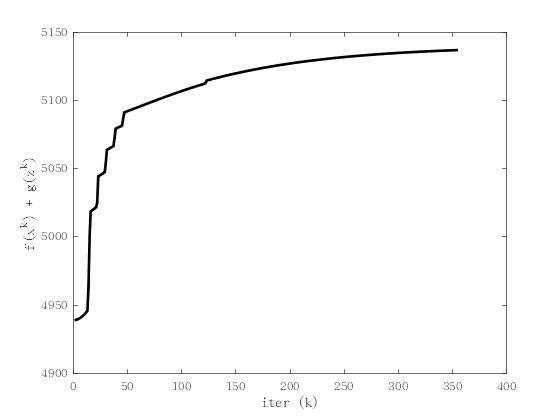

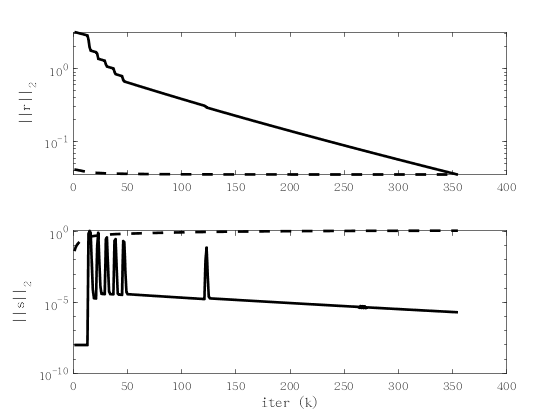

In [8]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');